## Introduction

This notebook gives an overview of the `pulser-diff` package and introduces its features and possibilities. `pulser-diff` in its essence is a PyTorch-based differentiable backend for the [Pulser](https://pulser.readthedocs.io/en/stable/) framework. It allows for composing, simulating and executing pulse sequences for neutral-atom quantum devices. Moreover, the result of Schrödinger equation solver can be differentiated with respect to sequence evaluation times $\{t_i\}_{i=1}^{N}$ or any parameters that define the constituent pulses of the sequence, e. g., amplitude $\Omega$, detuning $\delta$ or phase $\phi$. This feature is facilitated by the auto-differentiation capabilities of the underlying `torch` library. 

Differentiability of `pulser-diff`'s simulation result $\psi(\theta_i)$ with respect to various sequence parameters $\theta_i$ also means that a user can implement optimization strategies based on minimization of an arbitrary user-defined loss function $l(\theta_i)$. This opens the possibility to optimize pulse parameters in different contexts, such as finding the best parameters for some state preparation problem or the optimal pulse shaping that implement the desired gate with highest fidelity on a given quantum machine with specific hardware constraints. 

In the following sections we will present both the low-level features of `pulser-diff` showcasing how to calculate and visualize explicit derivatives and the higher-level optimization API for various pulse optimization tasks.

## 1. Derivative calculation

First we import the necessary objects from `pulser` and `pyqtorch`.

In [1]:
import torch
from torch import Tensor

from typing import Callable

from pulser import Sequence, Pulse, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform, CustomWaveform, ConstantWaveform

from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import deriv_time, deriv_param
from pulser_diff.utils import IMAT, ZMAT, kron

import matplotlib.pyplot as plt
from scipy import interpolate

from pyqtorch.utils import SolverType

### 1.1 Defining the sequence

Since `pulser-diff` is a Pulser backend, the general workflow for defining a pulse sequence is identical. Thus, first we define the atom register. Note that the coordinates of qubits $(x_i, y_i)$ are _differentiable parameters_.

In [2]:
# define coordinates of 4 qubits as torch tensors
# requires_grad=True instructs the auto-differentiation engine that gradients will be stored for these tensors 
# that will allow derivatives with respect to these parameters be calculated
q0_coords = torch.tensor([0.0, 0.0], requires_grad=True)
q1_coords = torch.tensor([0.0, 8.0], requires_grad=True)
q2_coords = torch.tensor([8.0, 0.0], requires_grad=True)
q3_coords = torch.tensor([8.0, 8.0], requires_grad=True)

# create register
reg = Register({"q0": q0_coords, "q1": q1_coords, "q2": q2_coords, "q3": q3_coords})
print(reg)

Register({'q0': tensor([0., 0.], dtype=torch.float64, grad_fn=<SelectBackward0>), 'q1': tensor([0., 8.], dtype=torch.float64, grad_fn=<SelectBackward0>), 'q2': tensor([8., 0.], dtype=torch.float64, grad_fn=<SelectBackward0>), 'q3': tensor([8., 8.], dtype=torch.float64, grad_fn=<SelectBackward0>)})


Now we create an empty sequence, define channels and define the parameters of pulses that will be added to the sequence.

In [3]:
# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
start_det = torch.tensor([-5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)
det = torch.tensor([0.0], requires_grad=True)
phase = torch.tensor([0.0], requires_grad=True)

# define time-dependent waveforms
amp_wf = BlackmanWaveform(800, area)
det_wf = RampWaveform(800, start_det, 0.0)

# add pulses
seq.add(Pulse(amp_wf, det_wf, 0), "rydberg_global")
seq.add(Pulse.ConstantPulse(800, omega, det, phase), "rydberg_global")

Note that all pulse parameters created above as tensors with the `requires_grad=True` argument. However, if differentiation with respect to some of them is not necessary, it is beneficial to set `requires_grad=False` for memory saving purposes. 

When creating pulses, it is possible to mix `torch` tensors and simple `float` values as pulse parameters.

Sequence simulation is performed using the standard Pulser interface. However, here we use the `torch`-based `TorchEmulator` class from `pulser-diff` to perform the numerical simulation instead of the `QutipEmulator` that uses the `qutip` package.

In [4]:
sim = TorchEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(time_grad=True, dist_grad=True, solver=SolverType.DP5_SE)

The `time_grad=True` argument instructs the simulation to store gradients for all evaluation times, thus allowing the calculation for output derivatives with respect to these times. Similarly, `dist_grad=True` enables the  calculation for derivatives with respect to inter-qubit distances $r_{ij}$ . We can also specify what solver from `pyqtorch` library to use for quantum dynamics simulation: `DP5_SE` - selects the Dormand-Prince-5 state vector solver, `KRYLOV_SE` selects the Krylov subspace method state vector solver.

The `results` object contains the values of the system's wavefunction at times stored in the `sim.evaluation_times` tensor. Both these quantities are `torch` tensors.

In [5]:
print("Evaluation times:")
print(sim.evaluation_times)
print()
print("Wavefunctions:")
print(results.states)

Evaluation times:
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1610, 0.1710,
        0.1810, 0.1910, 0.2010, 0.2110, 0.2210, 0.2310, 0.2410, 0.2510, 0.2610,
        0.2710, 0.2810, 0.2910, 0.3010, 0.3110, 0.3220, 0.3320, 0.3420, 0.3520,
        0.3620, 0.3720, 0.3820, 0.3920, 0.4020, 0.4120, 0.4220, 0.4320, 0.4420,
        0.4520, 0.4620, 0.4720, 0.4830, 0.4930, 0.5030, 0.5130, 0.5230, 0.5330,
        0.5430, 0.5530, 0.5630, 0.5730, 0.5830, 0.5930, 0.6030, 0.6130, 0.6230,
        0.6330, 0.6440, 0.6540, 0.6640, 0.6740, 0.6840, 0.6940, 0.7040, 0.7140,
        0.7240, 0.7340, 0.7440, 0.7540, 0.7640, 0.7740, 0.7840, 0.7940, 0.8050,
        0.8150, 0.8250, 0.8350, 0.8450, 0.8550, 0.8650, 0.8750, 0.8850, 0.8950,
        0.9050, 0.9150, 0.9250, 0.9350, 0.9450, 0.9550, 0.9660, 0.9760, 0.9860,
        0.9960, 1.0060, 1.0160, 1.0260, 1.0360, 1.0460, 1.0560, 1.0660, 1.0760,
        1.0860, 1.0960

Using the `results` object allows to further calculate the necessary quantities, e. g., using the `expect` method to get expectation values at each evaluation time for some observable $\hat{C}$. 

In [6]:
# create total magnetization observable
n_qubits = len(reg._coords)
total_magnetization = []
for i in range(n_qubits):
    tprod = [IMAT for _ in range(n_qubits)]
    tprod[i] = ZMAT
    total_magnetization.append(kron(*tprod))
total_magnetization = sum(total_magnetization)

# calculate expectation values
exp_val = results.expect([total_magnetization])[0].real

### 1.2 Calculating the time derivative

The calculation for the time derivative for some expectation values is performed using the `deriv_time` function:

In [7]:
# calculate time derivative
eval_times = sim.evaluation_times
pulse_endtimes = sim.endtimes
grad_time = deriv_time(f=exp_val, times=eval_times, pulse_endtimes=pulse_endtimes)

The last argument `pulse_endtimes` to function `deriv_time` is used to provide the indices for the pulse start/end times in the `eval_times` tensor. This is needed to avoid possible spurious derivative behaviours at the boundaries between two ideal pulses.

In order to check that the calculated time derivative is correct, we can create an interpolated function from expectation values using `scipy.interpolate` and find the corresponding derivative.

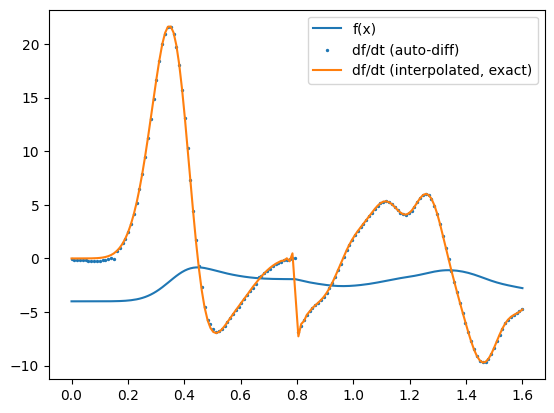

In [8]:
# calculate the exact derivative with respect to time
x = eval_times.detach().numpy()
y = exp_val.detach().numpy()
interp_fx = interpolate.UnivariateSpline(x, y, k=5, s=0)
dfdt_exact = interp_fx.derivative()(x)

# visualize expectation values and time derivatives
plt.plot(x, y, label="f(x)")
plt.scatter(x, grad_time.detach().numpy(), s=2, label="df/dt (auto-diff)")
plt.plot(x, dfdt_exact, label="df/dt (interpolated, exact)")
plt.legend()

We can see that time derivative calculated using `torch` auto-differentiation engine closely match the exact derivative.

### 1.3 Calculating derivatives with respect to pulse or register parameters

The workflow is identical as when calculating the time derivative. Now, `pulser-diff` provides the `deriv_param` function.

Let us calculate derivatives of expectation value with respect to amplitude `omega` of the second constant pulse of the sequence, to coordinates of qubit `q1` and inter-qubit distance `r` between qubits `q1` and `q3`. We can obtain all these derivative values by passing the necessary parameters to `deriv_param` in a single list.

In [9]:
exp_val

tensor([-4.0000, -4.0000, -4.0000, -4.0000, -4.0000, -4.0000, -4.0000, -3.9999,
        -3.9998, -3.9996, -3.9992, -3.9986, -3.9975, -3.9959, -3.9933, -3.9894,
        -3.9831, -3.9746, -3.9629, -3.9468, -3.9254, -3.8971, -3.8606, -3.8141,
        -3.7559, -3.6843, -3.5975, -3.4941, -3.3729, -3.2333, -3.0754, -2.9000,
        -2.6886, -2.4832, -2.2696, -2.0530, -1.8390, -1.6338, -1.4434, -1.2732,
        -1.1279, -1.0108, -0.9236, -0.8665, -0.8380, -0.8355, -0.8553, -0.8932,
        -0.9504, -1.0120, -1.0789, -1.1482, -1.2174, -1.2850, -1.3497, -1.4111,
        -1.4687, -1.5226, -1.5727, -1.6192, -1.6620, -1.7013, -1.7371, -1.7693,
        -1.8005, -1.8251, -1.8465, -1.8647, -1.8800, -1.8925, -1.9025, -1.9103,
        -1.9163, -1.9206, -1.9237, -1.9256, -1.9268, -1.9274, -1.9276, -1.9338,
        -2.0003, -2.0664, -2.1265, -2.1816, -2.2326, -2.2803, -2.3253, -2.3679,
        -2.4081, -2.4455, -2.4796, -2.5097, -2.5352, -2.5553, -2.5695, -2.5775,
        -2.5792, -2.5745, -2.5642, -2.54

In [10]:
# create tensor of times (in ns) where derivative will be evaluated
times = torch.linspace(0.0, 1600, 40)

# we want to calculate derivative with respect to distance between qubits q0 and q3
qq_distances = sim.qq_distances
r = qq_distances["q0-q3"]

# calculate derivative values at each time
diff_params = [omega, q1_coords, r]
grads = []
for t in times:
    grad_param = deriv_param(f=exp_val, x=diff_params, times=eval_times, t=t)
    grads.append(torch.hstack(grad_param))
grads = torch.stack(grads)

Similarly we can calculate derivatives with respect to qubit coordinates. Let's now plot some results.

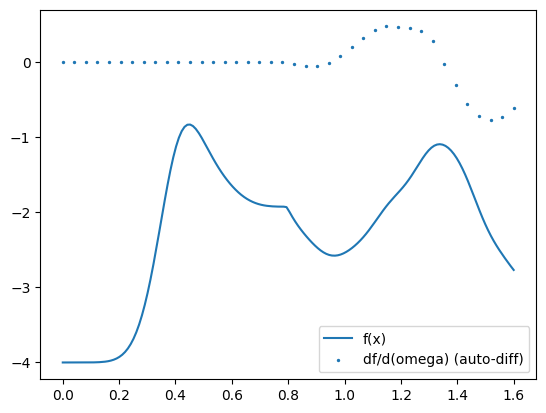

In [11]:
# visualize derivative with respect to amplitude
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:,0].numpy(), s=2, label="df/d(omega) (auto-diff)")
plt.legend()

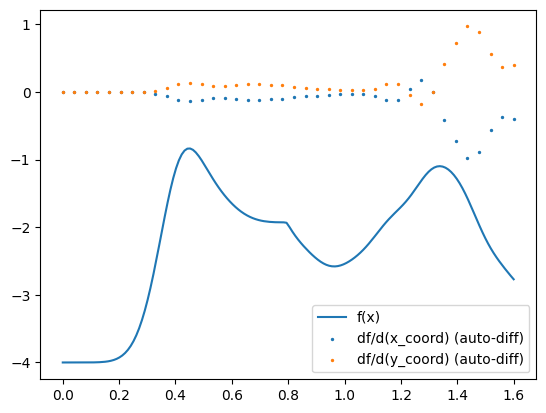

In [12]:
# visualize derivatives with respect to coordinates
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:,1].numpy(), s=2, label="df/d(x_coord) (auto-diff)")
plt.scatter(times.numpy()/1000, grads[:,2].numpy(), s=2, label="df/d(y_coord) (auto-diff)")
plt.legend()

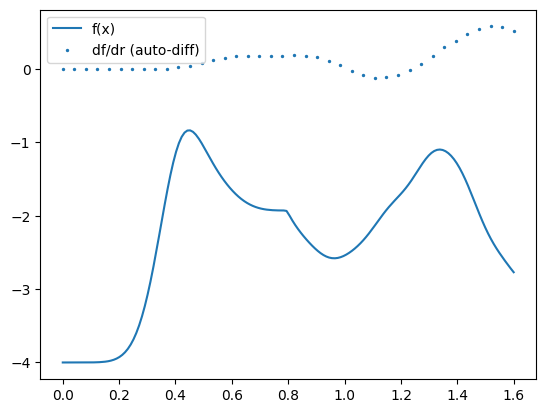

In [13]:
# visualize derivative with repsect to inter-qubit distance
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:, 3].numpy(), s=2, label="df/dr (auto-diff)")
plt.legend()

## 2. Sequence optimization

In the previous section, we demonstrated that `pulser-diff` is able to calculate first-order derivatives ${\rm d}l(\theta)/{\rm d}\theta_{i}$ for some output function $l(\theta)$ with respect to various pulse and register parameters $\theta_i$. `pulser-diff` can therefore be integrated in machine learning pipelines as a framework where a loss function is minimized using gradient-based approaches to optimize system parameters of choice. Here, the system is the pulse sequence, the loss function can be any function of the output of the state-vector simulator and the optimizable parameters are pulse, register and observable parameters. Let us now demonstrate how such optimization can be performed.

The optimization API of `pulser-diff` is built around a `QuantumModel` class that enables the conversion of standard Pulser sequences into a `torch.nn.Module`. This enables the seamless integration into usual PyTorch ML workflows including optimizers and schedulers selection as well as optimization loop customization. Let us import the `QuantumModel` object.

In [2]:
from pulser_diff.model import QuantumModel

### 2.1 Pulse parameter optimization

To showcase the basic workflow for sequence optimization, let's define first a toy problem. Let us assume that we need to find the parameters of a pulse sequence such that the expectation value $f(\theta)=\left\langle \psi(\theta)\right|\hat{C}\left|\psi(\theta)\right\rangle $ of an observable $\hat{C}$ is equal to a predefined value, for instance $f_0=-0.5$. We can achieve this goal by optimizing any or all parameters from these two groups:

1. Pulse parameters - amplitude $\Omega$, detuning $\delta$, phase $\phi$, duration $\tau_n$
2. Register parameters - qubit coordinates $(x_i, y_i)$

<div class="alert alert-block alert-warning">
<b>Note:</b> Pulse duration optimization is currently supported for sequences containing only constant pulses.
</div>

We first define a sequence consisting of one constant and one time-dependent pulse and assume that we want to optimize the amplitude of the constant pulse and the area of the time-dependent one.

In [15]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# declare sequence variables
omega_param = seq.declare_variable("omega")
area_param = seq.declare_variable("area")

# create pulses
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, area_param)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")

The created sequence is a standard Pulser parametrized sequence from declaring two variables `omega` for constant pulse's amplitude and `area` for Blackman pulse's area. `pulser-diff` utilizes Pulser's variable system to define optimizable sequence parameters. This is valid for any pulse parameter that supports Pulser's `Variable` object as an argument.

To optimize this sequence we first have to wrap it in a `QuantumModel` object and supply initial values for `omega` and `area`.

In [16]:
# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)

# create quantum model from sequence
trainable_params = {"omega": omega, "area": area}
constraints = {
    "omega": {"min": 4.5, "max": 5.5}
}
model = QuantumModel(seq, trainable_params, constraints=constraints, sampling_rate=0.5, solver=SolverType.KRYLOV_SE)

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


seq_param_values.area
Parameter containing:
tensor([3.1416], requires_grad=True)
-------
seq_param_values.omega
Parameter containing:
tensor([5.], requires_grad=True)
-------


We can see from the code snippet above that initial values for the optimizable parameters are provided as `torch.Tensor` objects with `requires_grad=True`. This falls in line with the paradigm of PyTorch of creating a computational graph that facilitates gradient calculations with respect to leaf nodes, in our case the user-created `omega` and `area` tensors. Note that `trainable_params` dict key values must be identical to the Pulser sequence variables defined previously.

An optional dict can be passed to the `QuantumModel` constructor with a supplementary `constraints` argument, that defines the min/max range of optimizable parameters. Here, we specified that the `omega` parameter value must not fall out of the range $[4.5, 5.5]$. Internally such constraints are enforced by using the `torch.clamp` function that allows gradient flow and simultaneously keeps the parameter value strictly in range.

Finally, we print the optimizable parameters of the created `QuantumModel` instance to confirm that `omega` and `area` are indeed registered and will be visible to the PyTorch optimizer. The optimizer is defined in a standard way along with the loss function that in our case is the simple MSE loss.

In [17]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

With loss function and optimizer in place we can now construct an optimization loop to solve the problem. 

In [7]:
def run_opt_loop(model: QuantumModel, 
                 target_value: Tensor, 
                 optimizer: torch.optim.Optimizer,
                 loss_fn: Callable,
                 epochs: int = 100, 
) -> None:
    
    # print initial expectation value as a result of simulating initial sequence
    _, init_exp_val = model.expectation()
    print("Initial expectation value:", init_exp_val[-1])
    print()

    # optimize model parameters so that the final output expectation value matches the predefined value
    for t in range(epochs):
        # calculate prediction and loss
        _, exp_val = model.expectation()
        loss = loss_fn(exp_val.real[-1], target_value)

        # standard backpropagation
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

        # enforce constraints on optimizable parameters
        model.check_constraints()

        print(f"[{t}] loss: {loss:>7f}")

        if loss < 0.00001:
            break

        # update sequence with changed pulse parameter values
        model.update_sequence()

    # print expectation value with optimized model
    _, init_exp_val = model.expectation()
    print()
    print("Optimized expectation value:", init_exp_val[-1])
    print()

In [18]:
# run optimization loop
target_value = torch.tensor(-0.5, dtype=torch.float64)
run_opt_loop(model, target_value, optimizer, loss_fn, 100)

Initial expectation value: tensor(-1.2763+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)

[0] loss: 0.602630
[1] loss: 0.511404
[2] loss: 0.416565
[3] loss: 0.323062
[4] loss: 0.235741
[5] loss: 0.158972
[6] loss: 0.096202
[7] loss: 0.049484
[8] loss: 0.019127
[9] loss: 0.003641
[10] loss: 0.000086
[11] loss: 0.003037
[12] loss: 0.005175
[13] loss: 0.007339
[14] loss: 0.009370
[15] loss: 0.011185
[16] loss: 0.012749
[17] loss: 0.014054
[18] loss: 0.015110
[19] loss: 0.015934
[20] loss: 0.016543
[21] loss: 0.016714
[22] loss: 0.016053
[23] loss: 0.014692
[24] loss: 0.012802
[25] loss: 0.010579
[26] loss: 0.008227
[27] loss: 0.005940
[28] loss: 0.003890
[29] loss: 0.002212
[30] loss: 0.000992
[31] loss: 0.000264
[32] loss: 0.000003

Optimized expectation value: tensor(-0.4983+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)



The optimization loop above follows the standard PyTorch rules with a couple of additional adjustments. Namely, we call the `check_constraints()` method of the `model` to ensure that all optimizable parameters fall in range with any given constraints. Then the `update_sequence()` method is called to reconstruct the underlying Pulser sequence with optimized values of parameters. This concludes a single optimization iteration and prepares for the next one. 

As we can see, after 32 iterations the loss decreased significantly and the target value of $-0.5$ was achieved with high accuracy. Printing the optimizable parameters of the model confirms that their values indeed changed.

In [19]:
print()
for name, param in model.named_parameters():
    print(name, param)
    print('-------')


seq_param_values.area Parameter containing:
tensor([2.5058], requires_grad=True)
-------
seq_param_values.omega Parameter containing:
tensor([4.6157], requires_grad=True)
-------


Finally, we can use the `built_seq` property of the `QuantumModel` instance and call the standard Pulser `draw()` method to visualize the optimized sequence.

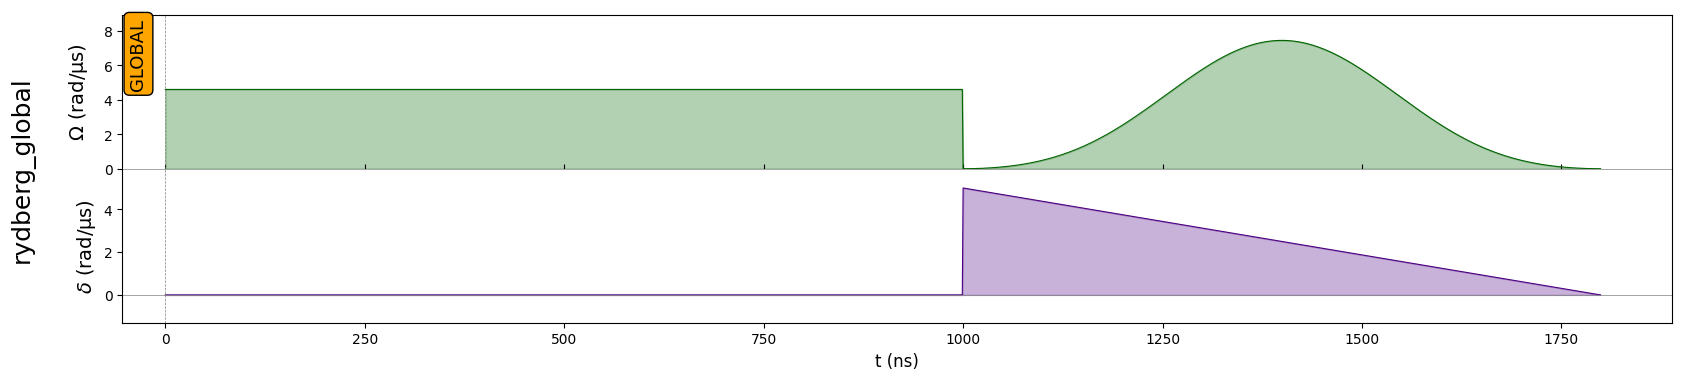

In [20]:
model.built_seq.draw()

### 2.2 Register parameter optimization

Let us say that for a different task we want to optimize the pulse amplitude `omega` and also the positions of the qubits in the register. To achieve this we need to instruct the `QuantumModel` to handle qubit coordinates as optimizable parameters. To do this, let us recreate the register by specifying explicit qubit coordinates and constructing a similar sequence.

In [21]:
# create register
q0_coords = torch.tensor([0.5, 0.4], requires_grad=True)
q1_coords = torch.tensor([8.3, 0.1], requires_grad=True)
reg = Register({"q0": q0_coords, "q1": q1_coords})

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# declare sequence variables
omega_param = seq.declare_variable("omega")

# create pulses
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, 3.14)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")

Here we defined only a single sequence variable `omega` and specified qubit coordinates using `torch` tensors that require gradients. Setting `requires_grad=True` when creating qubit coordinates essentially serves the same purpose as declaring sequence variables with `declare_variable()` method. To instruct the `QuantumModel` to register qubit coordinates as optimizable parameters we must include them in the `trainable_params` dict as well.

In [22]:
# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)

# create quantum model from sequence
trainable_params = {
    "omega": omega, 
    "q0": q0_coords,
    "q1": q1_coords,
}
constraints = {
    "omega": {"min": 4.5, "max": 5.5}
}
model = QuantumModel(seq, trainable_params, constraints=constraints, sampling_rate=0.5, solver=SolverType.KRYLOV_SE)

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


seq_param_values.omega
Parameter containing:
tensor([5.], requires_grad=True)
-------
reg_param_values.q0
Parameter containing:
tensor([0.5000, 0.4000], requires_grad=True)
-------
reg_param_values.q1
Parameter containing:
tensor([8.3000, 0.1000], requires_grad=True)
-------


Now we can run the usual optimization loop.

In [23]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# run optimization loop
target_value = torch.tensor(-0.5, dtype=torch.float64)
run_opt_loop(model, target_value, optimizer, loss_fn, 100)

Initial expectation value: tensor(-1.4701+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)

[0] loss: 0.941186
[1] loss: 0.740986
[2] loss: 0.446993
[3] loss: 0.141663
[4] loss: 0.050000
[5] loss: 0.023811
[6] loss: 0.000827
[7] loss: 0.070675
[8] loss: 0.140152
[9] loss: 0.142601
[10] loss: 0.097798
[11] loss: 0.039629
[12] loss: 0.005480
[13] loss: 0.000382
[14] loss: 0.004977
[15] loss: 0.008452
[16] loss: 0.009640
[17] loss: 0.009751
[18] loss: 0.009751
[19] loss: 0.010045
[20] loss: 0.010649
[21] loss: 0.011340
[22] loss: 0.012268
[23] loss: 0.014119
[24] loss: 0.015349
[25] loss: 0.015725
[26] loss: 0.015227
[27] loss: 0.014037
[28] loss: 0.012451
[29] loss: 0.010771
[30] loss: 0.009224
[31] loss: 0.007932
[32] loss: 0.006925
[33] loss: 0.006174
[34] loss: 0.005628
[35] loss: 0.005229
[36] loss: 0.004927
[37] loss: 0.004681
[38] loss: 0.004460
[39] loss: 0.004243
[40] loss: 0.004016
[41] loss: 0.003767
[42] loss: 0.003490
[43] loss: 0.003179
[44] loss: 0.002830
[45] loss: 

In [24]:
# register/sequence parameters after optimization
print()
for name, param in model.named_parameters():
    print(name, param)
    print('-------')


seq_param_values.omega Parameter containing:
tensor([4.5000], requires_grad=True)
-------
reg_param_values.q0 Parameter containing:
tensor([0.2341, 0.4370], requires_grad=True)
-------
reg_param_values.q1 Parameter containing:
tensor([8.5659, 0.0630], requires_grad=True)
-------


### 2.3 Pulse duration optimization

In previous optimization examples, we assumed constant pulse durations. However `pulser-diff` allows optimizing these parameters as well. Note, that currently only constant-pulse sequences support duration optimization. 

Let us create a sequence containing 3 constant pulses first.

In [25]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# declare sequence variables
dur1_param = seq.declare_variable("dur1")
omega_param = seq.declare_variable("omega")
dur2_param = seq.declare_variable("dur2")

# create pulses
pulse1 = Pulse.ConstantPulse(dur1_param, 2.0, 0.5, 0.0)
pulse2 = Pulse.ConstantPulse(400, omega_param, 0.0, 0.0)
pulse3 = Pulse.ConstantPulse(dur2_param, 3.0, 1.0, 0.0)

# add pulses
seq.add(pulse1, "rydberg_global")
seq.add(pulse2, "rydberg_global")
seq.add(pulse3, "rydberg_global")

Here the duration parameters are specified similarly as the amplitude - using Pulser's `declare_variable()` function. Now we can pass the created sequence to the `QuantumModel` constructor together with initial values for optimizable parameters.

In [26]:
# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
dur1 = torch.tensor([0.4], requires_grad=True)  # note that duration here is specified in us not ns
dur2 = torch.tensor([0.2], requires_grad=True)

# create quantum model from sequence
trainable_params = {
    "omega": omega, 
    "dur1": dur1,
    "dur2": dur2,
}
model = QuantumModel(seq, trainable_params, sampling_rate=0.5, solver=SolverType.KRYLOV_SE)

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


seq_param_values.omega
Parameter containing:
tensor([5.], requires_grad=True)
-------
seq_param_values.dur2
Parameter containing:
tensor([0.2000], requires_grad=True)
-------
seq_param_values.dur1
Parameter containing:
tensor([0.4000], requires_grad=True)
-------


It is important to note that duration parameter must be specified in microseconds instead of nanoseconds as in Pulser. The reason for this is to have duration parameter values more or less on the same scale as other pulse characteristics for optimizer to be able to work with a single learning rate for all trainable parameters.

Let us visualize the initial sequence.

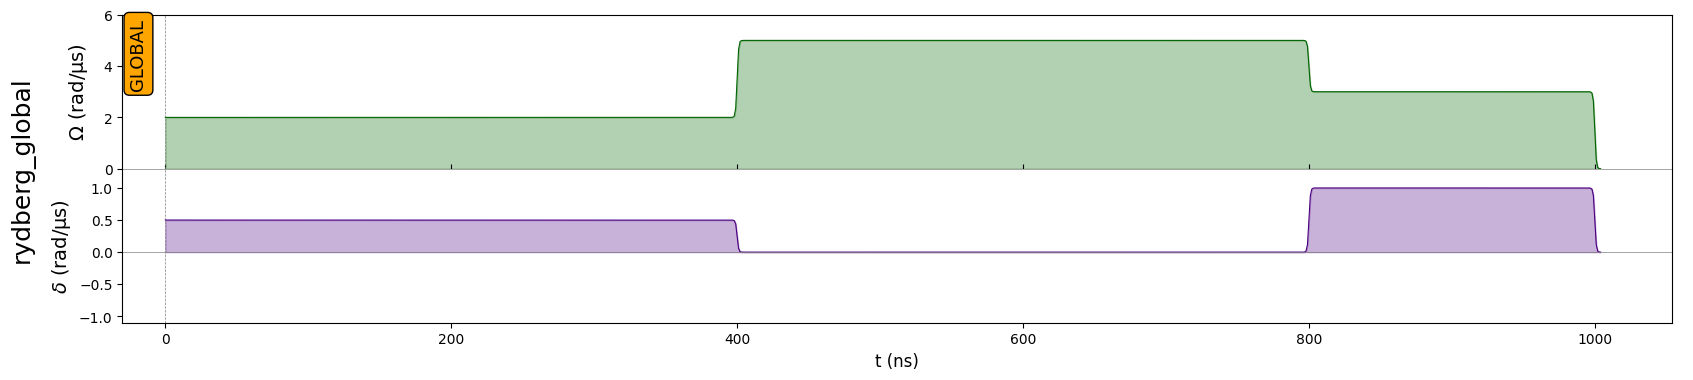

In [27]:
model.built_seq.draw()

We can notice that even though the sequence seems to be created from perfect constant pulses with sharp edges, the actual shape of pulses is smoothed. This is due to the fact that `QuantumModel` internally converts the original sequence into a sequence consisting of a number of 1 ns constant pulses parametrized by variables of the original sequence. This produces smooth amplitude $f_{\Omega,\tau}(t)$, detuning $f_{\delta,\tau}(t)$ and phase $f_{\phi,\tau}(t)$ envelopes, to mimick the original sequence but supports differentiation with respect to pulse durations $\tau$. This turns out to be possible by setting pulse durations as parameters for those envelopes functions.

To run the optimization we again define the loss, optimizer and call the optimization loop funtion.

In [28]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# run optimization loop
target_value = torch.tensor(-0.5, dtype=torch.float64)
run_opt_loop(model, target_value, optimizer, loss_fn, 100)

Initial expectation value: tensor(-1.0706+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)

[0] loss: 0.325592
[1] loss: 0.245923
[2] loss: 0.176822
[3] loss: 0.119215
[4] loss: 0.073794
[5] loss: 0.040838
[6] loss: 0.015497
[7] loss: 0.003325
[8] loss: 0.000037
[9] loss: 0.002506
[10] loss: 0.008470
[11] loss: 0.014847
[12] loss: 0.021034
[13] loss: 0.024638
[14] loss: 0.027541
[15] loss: 0.026635
[16] loss: 0.022155
[17] loss: 0.019871
[18] loss: 0.013906
[19] loss: 0.010865
[20] loss: 0.005966
[21] loss: 0.003664
[22] loss: 0.001322
[23] loss: 0.000079
[24] loss: 0.000028
[25] loss: 0.000988
[26] loss: 0.001777
[27] loss: 0.003156
[28] loss: 0.005335
[29] loss: 0.006514
[30] loss: 0.006911
[31] loss: 0.007057
[32] loss: 0.005859
[33] loss: 0.005670
[34] loss: 0.003641
[35] loss: 0.002704
[36] loss: 0.001292
[37] loss: 0.000299
[38] loss: 0.000001

Optimized expectation value: tensor(-0.5012+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)



It is also possible to specify different learning rate for the duration parameters to improve convergence speed. To achieve this we can create a list `opt_params` that will contain optimizable parameters together with custom learning rates, if necessary.

```
# set different learning rate for duration parameter(s)
opt_params = []
dur_params = ["dur1", "dur2"]
for name, p in list(model1.named_parameters()):
    d = {"params": p}
    if name.split(".")[-1] in dur_params:
        d["lr"] = 0.01
    opt_params.append(d)

# create optimizer
optimizer = torch.optim.Adam(opt_params, lr=0.1)
```

This optimizer will use `lr=0.01` for duration parameters and `lr=0.1` for all the rest of parameters.

In [29]:
# register/sequence parameters after optimization
print()
for name, param in model.named_parameters():
    print(name, param)
    print('-------')


seq_param_values.omega Parameter containing:
tensor([4.8984], requires_grad=True)
-------
seq_param_values.dur2 Parameter containing:
tensor([0.1233], requires_grad=True)
-------
seq_param_values.dur1 Parameter containing:
tensor([0.3284], requires_grad=True)
-------


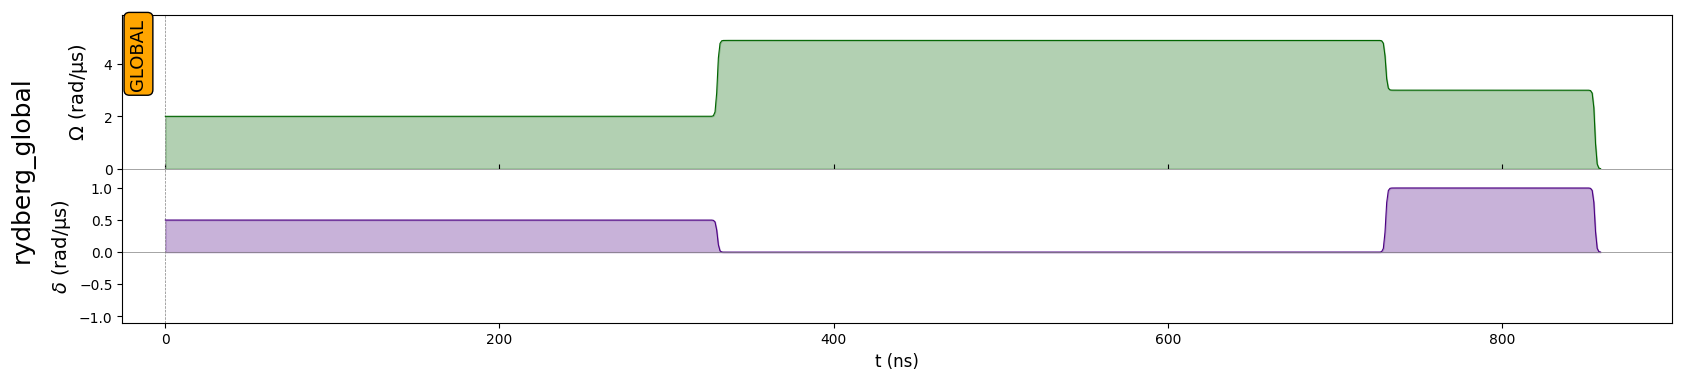

In [ ]:
# optimized sequence visualization
model.built_seq.draw()

Since the `built_seq` above is the internal representation with discretized pulses, one might want to build the original parameterized sequence with the obtained optimized parameters. This can be easily done by passing `named_parameters` of the model to the original parameterized sequence `seq`.

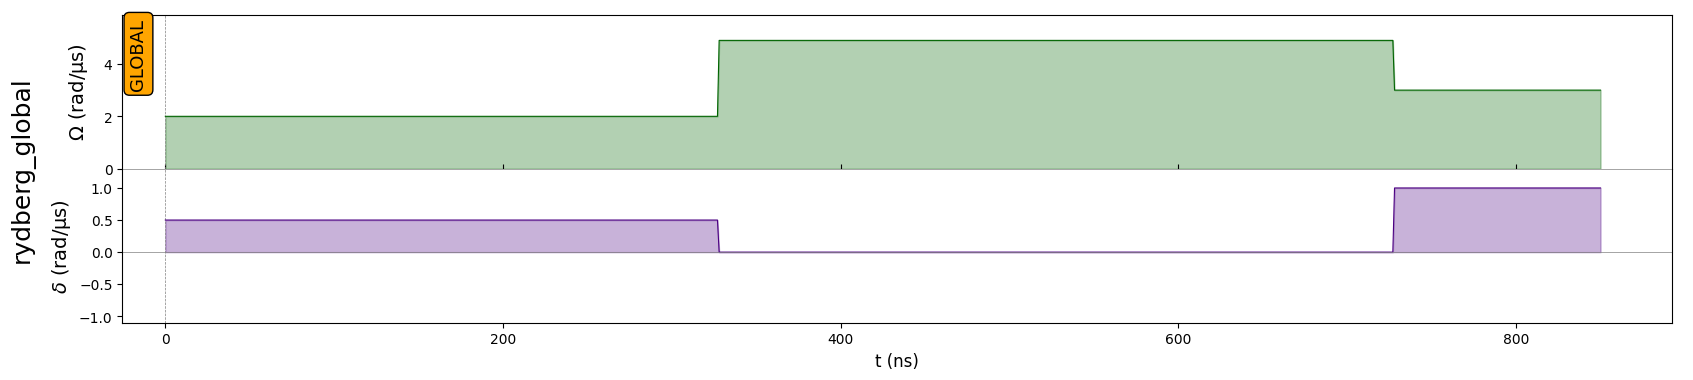

In [ ]:
duration_params = ["dur1", "dur2"]
final_param_values = {}
for name, value in model.named_parameters():
    name = name.split(".")[-1]
    if name in duration_params:
        value = int(value.data*1000)
    else:
        value = value.data
    final_param_values[name] = value

seq.build(**final_param_values).draw()

### 2.4 Pulse shape optimization

In situations when finer-grained control over pulse shapes is required the existing Pulser's parametrized pulses with predefined shapes might not be sufficient. For such cases Pulser has `CustomWaveform` object where an arbitrary array of values describes the waveform. In `pulser-diff` this custom waveform can be used for similar purpose.

In [3]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# declare sequence variables for predefined pulses
omega_param = seq.declare_variable("omega")
area_param = seq.declare_variable("area")

# create pulses with predefined shapes
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, area_param)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# create custom-shaped pulse
pulse_duration = 300
omega_custom_param = seq.declare_variable("omega_custom", size=pulse_duration)
cust_amp = CustomWaveform(omega_custom_param)
cust_det = ConstantWaveform(pulse_duration, 1.5)
pulse_custom = Pulse(cust_amp, cust_det, 0.0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")
seq.add(pulse_custom, "rydberg_global")

From the code above we can see that creation of the `CustomWaveform` is a bit different compared to predefined pulses. We pass the `CustomWaveform` constructor a single Pulser variable `omega_custom_param` that will hold all information about the pulse's shape. Since this information will be stored as an collection of numbers, the variable itself has size greater than 1, namely `size=pulse_duration`. Hence the duration of the `CustomWaveform` must be known in advance. Other than that creation of the custom pulse follows standard Pulser rules.

Now we can define the pulse shape itself by creating a function $g_{\theta}(t)$ in interval $[0, \tau]$ that accepts an arbitrary number of parameters $\{\theta_1, \theta_2,...\}$ and where $\tau$ is the duration of the pulse. Let us implement such a function consisting of sine and exponential functions.

In [4]:
def custom_wf(param1, param2):
    x = torch.arange(pulse_duration) / pulse_duration
    return param1 * torch.sin(torch.pi * x) * torch.exp(-param2 * x)

`custom_wf` creates a tensor of size 300 filled uniformly with values from 0 to 1 and then applies the sine and exponential functions on it. This way the output of `custom_wf` is a 300-element tensor with values aranged according to the mathematical operations defined above. In this case the governing parameters are `param1` and `param2` that modify the shape of the waveform.

Now we can create the `trainable_params` dict to denote parameters to optimize together with their corresponding initial values. `omega` and `area` parameters are specified as usual, however for the `omega_custom` parameter both governing variables `param1` and `param2` must be passed together with `custom_wf` function. 

In [5]:
# define pulse parameters
omega = torch.tensor(5.0, requires_grad=True)
area = torch.tensor(torch.pi, requires_grad=True)
param1 = torch.tensor(6.0, requires_grad=True)
param2 = torch.tensor(2.0, requires_grad=True)

# create quantum model from sequence
trainable_params = {
    "omega": omega, 
    "area": area,
    "omega_custom": ((param1, param2), custom_wf)
}
model = QuantumModel(seq, trainable_params, sampling_rate=0.5, solver=SolverType.KRYLOV_SE)

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


seq_param_values.omega
Parameter containing:
tensor(5., requires_grad=True)
-------
seq_param_values.area
Parameter containing:
tensor(3.1416, requires_grad=True)
-------
call_param_values.omega_custom_0
Parameter containing:
tensor(6., requires_grad=True)
-------
call_param_values.omega_custom_1
Parameter containing:
tensor(2., requires_grad=True)
-------


It is evident from the printout above that the actual parameters registered in the `QuantumModel` are the `param1` and `param2` tensors. Here `omega_custom` acts as a placeholder that binds both optimizable parameters, respective waveform function and the corresponding duration of the custom pulse. Actual values for the custom waveform are recalculated internally in the `QuantumModel` during each optimization iteration. 

Visualization of the initial sequence confirms that the third pulse indeed has a custom shape.

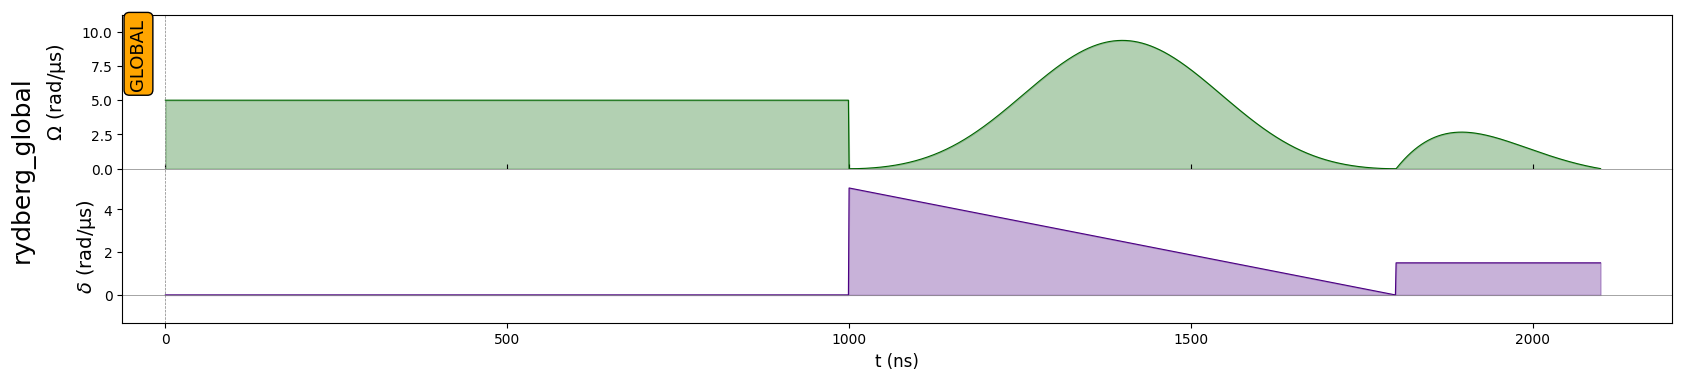

In [6]:
model.built_seq.draw()

Optimization procedure is identical to all previous cases.

In [8]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


# run optimization loop
target_value = torch.tensor(-0.5, dtype=torch.float64)
run_opt_loop(model, target_value, optimizer, loss_fn, 100)

Initial expectation value: tensor(-1.6479+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)

[0] loss: 1.317681
[1] loss: 1.260685
[2] loss: 1.211758
[3] loss: 1.093589
[4] loss: 0.904411
[5] loss: 0.668549
[6] loss: 0.423364
[7] loss: 0.212152
[8] loss: 0.069835
[9] loss: 0.006809
[10] loss: 0.004452
[11] loss: 0.030921
[12] loss: 0.061352
[13] loss: 0.084028
[14] loss: 0.096057
[15] loss: 0.098251
[16] loss: 0.092434
[17] loss: 0.080537
[18] loss: 0.064505
[19] loss: 0.046430
[20] loss: 0.028633
[21] loss: 0.013579
[22] loss: 0.003534
[23] loss: 0.000001

Optimized expectation value: tensor(-0.4992+0.j, dtype=torch.complex128, grad_fn=<SelectBackward0>)



In [9]:
# register/sequence parameters after optimization
print()
for name, param in model.named_parameters():
    print(name, param)
    print('-------')


seq_param_values.omega Parameter containing:
tensor(4.2468, requires_grad=True)
-------
seq_param_values.area Parameter containing:
tensor(1.3819, requires_grad=True)
-------
call_param_values.omega_custom_0 Parameter containing:
tensor(4.4225, requires_grad=True)
-------
call_param_values.omega_custom_1 Parameter containing:
tensor(3.5294, requires_grad=True)
-------
